In [1]:
from datetime import datetime
import pandas_datareader.data as web

stocks = ["ge", "intc", "amd", "gold", "spy", "ko", "pep"]
start, end = datetime(2017, 1, 1), datetime(2020, 1, 1)
df = web.DataReader(stocks, "yahoo", start=start, end=end)
df_prices = df["Adj Close"]

In [2]:
%load_ext autoreload
%autoreload 2
from simustocks.stocks import Stocks
from simustocks.simulation import Simulation

stocks_history = Stocks(df=df_prices)
expected_returns = {"ge": -0.8, "intc": 1, "amd": -0.1, "gold": -0.5, "spy": -0.99, "ko": 0.08, "pep": 0.01}
simu = Simulation(stocks_history.cov, er=list(expected_returns.values()), m=254)

In [3]:
init_prices = stocks_history.df.to_numpy()[-1:, :]  # (1, k)
future_returns, future_cov, future_prices = simu(order=12, init_prices=init_prices)

[ True  True  True  True  True  True  True]


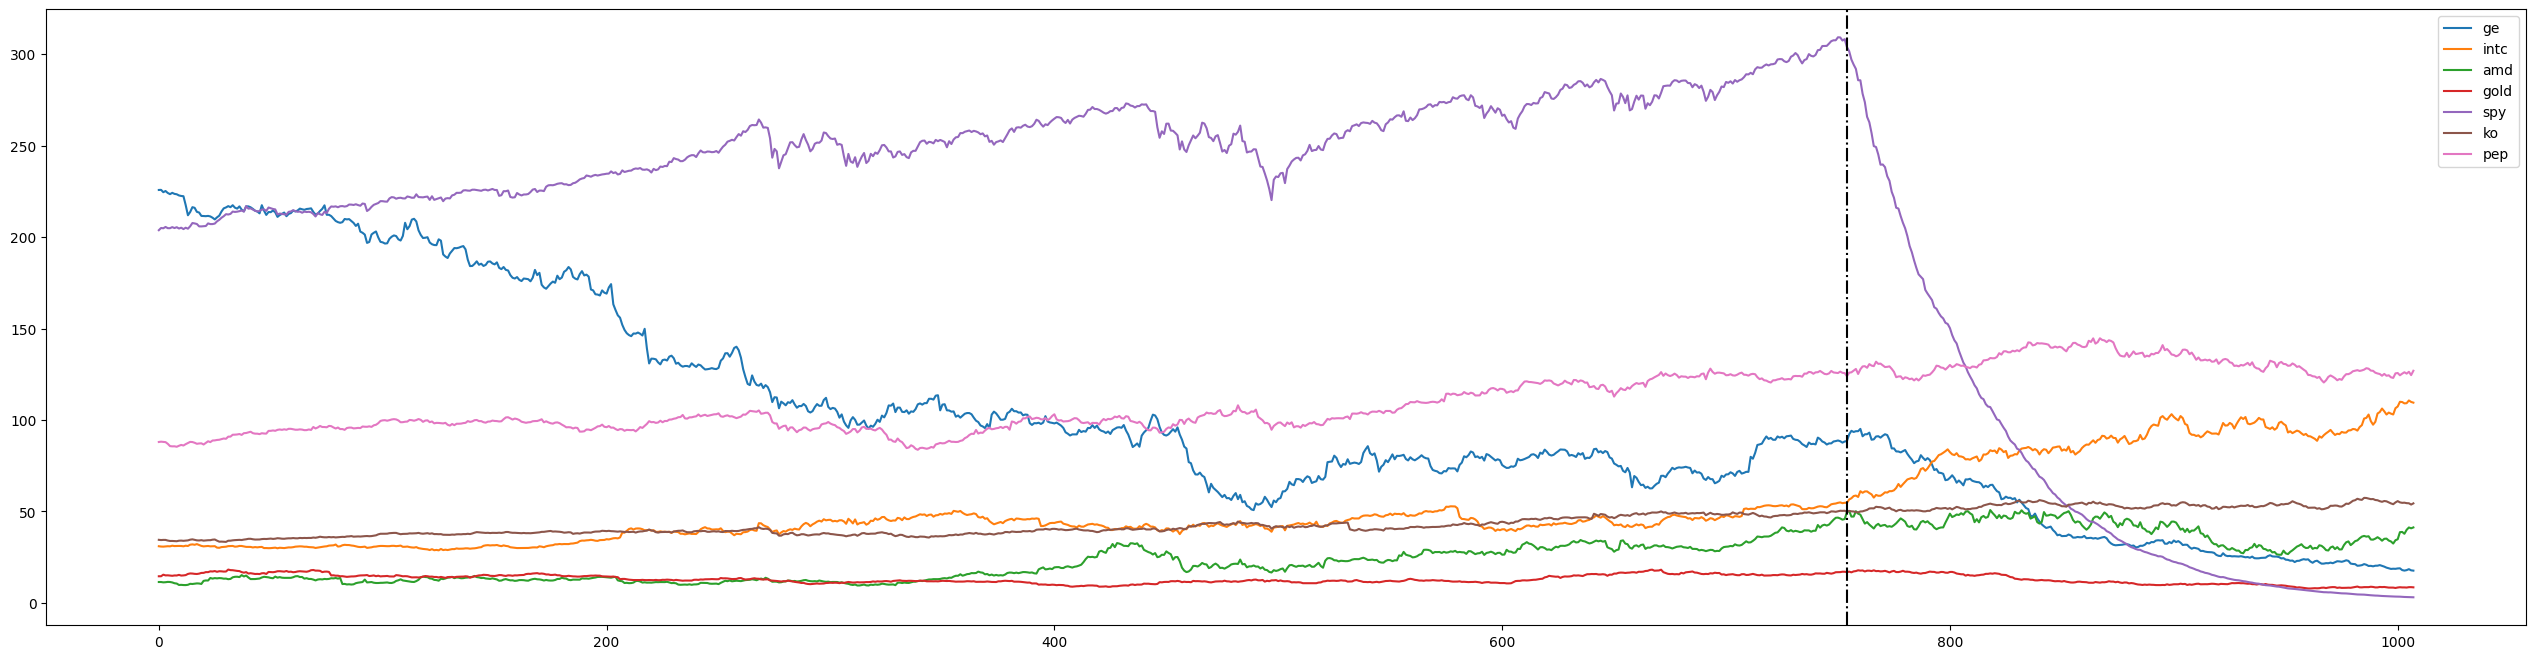

In [4]:
import numpy as np
import matplotlib.pyplot as plt

n = stocks_history.df.to_numpy().shape[0]
m = future_prices.shape[0]

# legend
stocks_names = stocks_history.df.columns
k = len(stocks_names)

prices = np.vstack((stocks_history.prices, future_prices[1:, :])) # n + m

fig, ax = plt.subplots(figsize=(32, 8))
ax.plot(prices, label=stocks_names);
# ax.vlines(x=n, ymin=0, ymax=np.max(future_prices[0, :]), c="r")
ax.axvline(x=n, ymin=0, ymax=1, c="black", linestyle="-.")
ax.legend();

In [5]:
expected_returns

{'ge': -0.8,
 'intc': 1,
 'amd': -0.1,
 'gold': -0.5,
 'spy': -0.99,
 'ko': 0.08,
 'pep': 0.01}